In [97]:
import pandas as pd
import isodate
import datetime
import matplotlib.pyplot as plt
import numpy as np

## Data Transformations

- Convert **duration**: From ISO 1806 string format to number of seconds
- Split Publish Time: Into Day, Month, Year, and Epoch Timestamp
- Compute **age**: Is a variable that accounts for how long a video has been on Youtube
- Log Transform: Values with large values (likes, views, comments) are log transformed to stabilize variance

In [292]:
df = pd.read_csv("data.csv")
df.dropna(inplace=True)
df["duration"] = df["duration"].apply(isodate.parse_duration).apply(datetime.timedelta.total_seconds)
df["publishedAt"] = df["publishedAt"].apply(isodate.parse_datetime)
df["publishedAtMonth"] = df["publishedAt"].apply(lambda dt: dt.month)
df["publishedAtDay"] = df["publishedAt"].apply(lambda dt: dt.day)
df["publishedAtYear"] = df["publishedAt"].apply(lambda dt: dt.year)
df["publishedAt"] = df["publishedAt"].apply(datetime.datetime.timestamp)
date_of_start = datetime.datetime(2019, 1, 1).timestamp()
df["age"] = (df["publishedAt"] - date_of_start)

df["log_views"] = np.log(df["views"])
df["log_likes"] = np.log(df["likes"])
df["comments"] = df["comments"].apply(lambda c: c+1) # to handle 0s
df["log_comments"] = np.log(df["comments"])

In [293]:
df[["views", "likes", "comments"]].corr()

,views,likes,comments
views,1.000000,0.837212,0.700777
likes,0.837212,1.000000,0.930700
comments,0.700777,0.930700,1.000000


We see high correlations between views, likes, and comments. So for the purposes of EDA and trend analysis, we could use any one of these variables instead of all of them.

In [294]:
df[["definition", "madeForKids"]].describe()

,definition,madeForKids
count,770,770
unique,2,2
top,hd,False
freq,745,745


The factors for **definition** and **madeForKids** are not equally balanced, so we will not look at trends across those values.

In [193]:
def get(df, col, val):
    return df[df[col] == val]

## Compare `views`  across `timePeriod`

In [133]:
before = get(df, "timePeriod", "before")
during = get(df, "timePeriod", "during")
after = get(df, "timePeriod", "after")

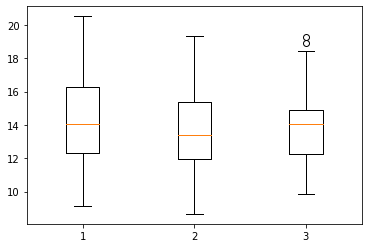

In [134]:
_ = plt.boxplot([before["log_views"], during["log_views"], after["log_views"]])

Surprisingly, there does not seem to be any drastic differences between number of views across different time periods of the pandemic. 

## Compare `views` across `category`

In [296]:
categories = list(df["category"].unique())
subsets = []
for c in categories:
    subsets.append(get(df, "category", c))

In [297]:
categories

['music',
 'comedy',
 'entertainment',
 'news/politics',
 'education',
 'science/tech']

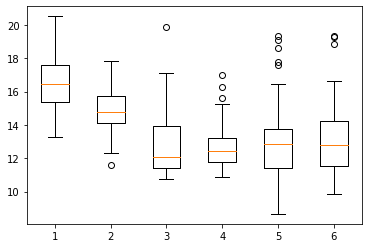

In [298]:
_ = plt.boxplot([s["log_views"] for s in subsets])

The light topics like music and comedy have more views as expected, but there are many more outliers in the more series topics. We can briefly investigate these outliers.

In [302]:
educ = get(df, "category", "education")
educ[educ["log_views"] > 16]

,videoId,publishedAt,category,timePeriod,title,duration,definition,caption,madeForKids,views,likes,comments,publishedAtMonth,publishedAtDay,publishedAtYear,age,log_views,log_likes,log_comments
246,UH2Sm0Wj3Dw,1.556003e+09,education,before,Potty Training Song | CoComelon Nursery Rhymes...,198.0,hd,True,True,201211220.0,641294.0,1.0,4,23,2019,9684004.0,19.119866,13.371243,0.0
248,KEZp5_DgABA,1.565075e+09,education,before,Nap Time Song | CoComelon Nursery Rhymes & Ki...,203.0,hd,True,True,255277576.0,554877.0,1.0,8,6,2019,18756002.0,19.357862,13.226502,0.0
538,q8ZlZBWnUmY,1.594710e+09,education,during,Lost Hamster | CoComelon Nursery Rhymes & Kids...,192.0,hd,False,True,119111700.0,479524.0,1.0,7,14,2020,48391209.0,18.595572,13.080549,0.0
539,j077GAqUQJ0,1.603177e+09,education,during,Halloween At School Song | CoComelon Nursery R...,227.0,hd,False,True,44703046.0,216468.0,1.0,10,20,2020,56858415.0,17.615552,12.285198,0.0
826,o-0t9cdY7Q8,1.643098e+09,education,after,Grocery Store Song | CoComelon Nursery Rhymes ...,189.0,hd,False,True,53570612.0,265753.0,1.0,1,25,2022,96778974.0,17.796511,12.490323,0.0
827,VR63WBMi3Wo,1.644912e+09,education,after,"Teddy Bear, Teddy Bear Song | CoComelon Nurser...",184.0,hd,False,True,13609426.0,75299.0,1.0,2,15,2022,98593207.0,16.426273,11.229222,0.0


All of these videos are `madeForKids` and were published by the same creator. One could argue these are not necessarily educative (for adults) so this is perhaps misclassified by the Youtube creators/algorithms

In [303]:
st = get(df, "category", "science/tech")
st[st["log_views"] > 16]

,videoId,publishedAt,category,timePeriod,title,duration,definition,caption,madeForKids,views,likes,comments,publishedAtMonth,publishedAtDay,publishedAtYear,age,log_views,log_likes,log_comments
250,ZRCdORJiUgU,1.576051e+09,science/tech,before,Google — Year in Search 2019,126.0,hd,True,False,155780775.0,464421.0,22683.0,12,11,2019,29732484.0,18.863960,13.048547,10.029371
253,vl6jn-DdafM,1.557866e+09,science/tech,before,We Are Going,228.0,hd,True,False,15926064.0,1289006.0,1.0,5,14,2019,11547294.0,16.583468,14.069382,0.000000
269,nA9UZF-SZoQ,1.550165e+09,science/tech,before,NASA Live: Official Stream of NASA TV's Media ...,0.0,sd,False,False,16849322.0,349915.0,2.0,2,14,2019,3845923.0,16.639821,12.765446,0.693147
550,4czjS9h4Fpg,1.614021e+09,science/tech,during,Perseverance Rover’s Descent and Touchdown on ...,206.0,hd,True,False,15949945.0,371527.0,26959.0,2,22,2021,67702616.0,16.584966,12.825377,10.202072
559,rokGy0huYEA,1.607501e+09,science/tech,during,Google — Year in Search 2020,181.0,hd,True,False,242500336.0,261699.0,17293.0,12,9,2020,61181985.0,19.306514,12.474950,9.758057
850,EqboAI-Vk-U,1.638950e+09,science/tech,after,Google — Year In Search 2021,121.0,hd,True,False,238007970.0,168548.0,8736.0,12,8,2021,92631652.0,19.287815,12.034976,9.075208


In [307]:
news = get(df, "category", "news/politics")
news[news["log_views"] > 15]

,videoId,publishedAt,category,timePeriod,title,duration,definition,caption,madeForKids,views,likes,comments,publishedAtMonth,publishedAtDay,publishedAtYear,age,log_views,log_likes,log_comments
150,tV9CcuD1QDY,1.555848e+09,news/politics,before,"BTS rehearses choreography of ""Boy With Luv""",214.0,hd,False,False,23657190.0,1173140.0,17439.0,4,21,2019,9529204.0,16.979178,13.975194,9.766464
151,sO-n-fqcV70,1.555438e+09,news/politics,before,Exclusive: North Korean Defector Whose Escape ...,121.0,hd,True,False,4319191.0,66511.0,5463.0,4,16,2019,9118793.0,15.278579,11.105123,8.605753
160,_Tc4e1KH0UU,1.549208e+09,news/politics,before,Linda Ronstadt speaks,575.0,hd,False,False,3646236.0,40216.0,6226.0,2,3,2019,2889679.0,15.109206,10.602020,8.736489
170,nDzhoofkRJI,1.566747e+09,news/politics,before,"Taylor Swift on ""Lover"" and haters",717.0,hd,False,False,3632943.0,106470.0,5380.0,8,25,2019,20428621.0,15.105554,11.575619,8.590444
171,HVVN1fmUjXM,1.579874e+09,news/politics,before,"Billie Eilish: ""Nobody that knows me thinks I'...",465.0,hd,False,False,5978171.0,164615.0,7118.0,1,24,2020,33555603.0,15.603625,12.011365,8.870382
450,qNZ8XCobUUM,1.611210e+09,news/politics,during,Katy Perry - Firework (Live from Celebrating A...,267.0,hd,False,False,11557542.0,476432.0,26015.0,1,21,2021,64891242.0,16.262849,13.074080,10.166429
774,ygkcwU0SWNk,1.635690e+09,news/politics,after,The return of ABBA,595.0,hd,False,False,3609730.0,56178.0,4857.0,10,31,2021,89370722.0,15.099144,10.936281,8.488176


All of these `news/politics` videos, while relevant to the category, are inherently about an entertainment related entity (Eg: News story about return of ABBA (music band) or live performance of Katy Perry (singer) at a political event)

## Compare `views` across `timePeriod` and `category`

In [333]:
leisure = subsets[0]
leisure_before = get(leisure, "timePeriod", "before")
leisure_during = get(leisure, "timePeriod", "during")
leisure_after = get(leisure, "timePeriod", "after")
professional = subsets[5]
professional_before = get(professional, "timePeriod", "before")
professional_during = get(professional, "timePeriod", "during")
professional_after = get(professional, "timePeriod", "after")

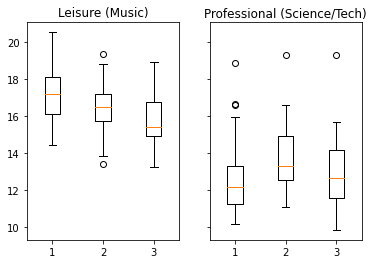

In [335]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.boxplot([(leisure_before["log_views"]), (leisure_during["log_views"]), (leisure_after["log_views"])])
_ = ax1.set_title("Leisure (Music)")
ax2.boxplot([(professional_before["log_views"]), (professional_during["log_views"]), (professional_after["log_views"])])
_ = ax2.set_title("Professional (Science/Tech)")

The views went up for Science/Tech videos published during the pandemic period

## Compare `duration` across `category`

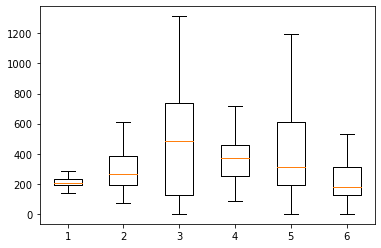

In [151]:
_ = plt.boxplot([s["duration"] for s in subsets], showfliers=False)

The music category seems to have the smallest durations of all categories. Entertainment and Education categories have a wider range of durations for their own respective reasons (Entertainment could include TV shows or candid interviews etc, and education includes tutorials or lectures which are long in length)

## Compare `duration` vs `views`

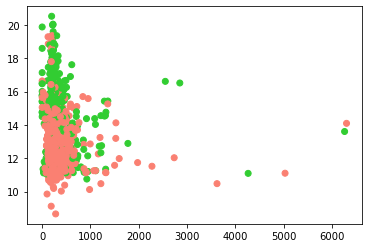

In [344]:
colors = {
    "science/tech": "salmon", 
    "education": "salmon",
    "news/politics": "salmon",
    "music": "limegreen", 
    "entertainment": "limegreen",
    "comedy": "limegreen",
}
_ = plt.scatter(df["duration"], df["log_views"], c=df["category"].map(colors))

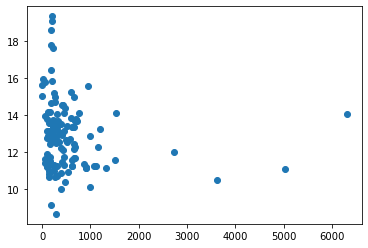

In [341]:
_ = plt.scatter(educ["duration"], educ["log_views"])

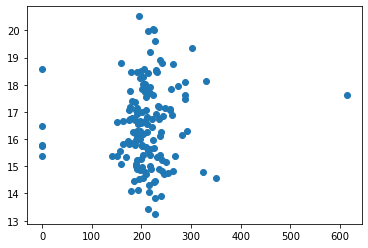

In [343]:
music = get(df, "category", "music")
_ = plt.scatter(music["duration"], music["log_views"])

There is mostly constant variance across all values of duration, so we expect duration to not have a big impact on the number of views.

Note: Youtube counts 30s of watching as a "view", so a lengthy video may still have a high view count even if it hasn't been watched completely

## Clustering

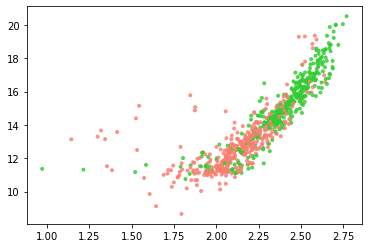

In [346]:
_ = plt.scatter(np.log(df["log_likes"]), df["log_views"], c=df["category"].map(colors), alpha=0.8, marker=".", s=35)

All professional categories are marked in salmon, and leisurely ones are in green. The difference is only in the number of views and likes, but there are many points that are not distinguishable i.e they have similar view/like counts but are of different categories.

We don't expect to see good clusters from clustering algorithms.

In [240]:
from sklearn.cluster import KMeans

In [274]:
kmeans = KMeans(n_clusters=2)

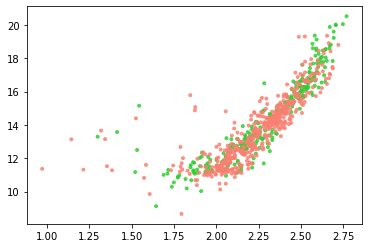

In [347]:
kfit = kmeans.fit(df[["duration", "age", "log_views", "log_likes", "log_comments", "publishedAt"]])
colors = {0: "salmon", 1: "limegreen"}
_ = plt.scatter(np.log(df["log_likes"]), df["log_views"], c=list(map(lambda l: colors[l], kfit.labels_)), alpha=0.8, marker=".", s=35)